In [15]:
import numpy as np
from sortedcontainers import SortedSet
from math import sqrt

In [16]:
class MyPriorityQueue(object):
    def __init__(self, current_heuristic, target):
        self.current_heuristic = current_heuristic
        self._data = SortedSet()
        self.target = target
        self.g = dict()
        self.h = dict()
    def __len__(self):
        return len(self._data)
    def push(self, item):
        node = (self.calculate_priority(item), self.get_heuristic(item), item)
        self._data.add(node)
    def pop(self):
        node = self._data.pop(0)[2]
        return node
    def manhattan_distance(self, x, y): ### Manhattan Distance-> heuristic = |x0-y0| + |x1-y1|, x = [x0,x1] y = [y0,y1]
        return abs(x[0] - y[0]) +abs(x[1] - y[1])
    def euclidean_distance(self, x, y): ### Euclidean Distance-> heuristic = sqrt( (x0-y0)**2 + (x1-y1)**2 ), x = [x0,x1]
                                        ##  y = [y0,y1]
        return sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)
    def chebyshev_distance(self, x, y): ### Chebyshev Distance-> heuristic = max(abs(x0-y0),abs(x1-y1)),
                                        ### x = [x0,x1] y = [y0,y1]
        return max(abs(x[0] - y[0]), abs(x[1] - y[1]))
    def get_heuristic(self, x):
        measure = self.current_heuristic
        if measure == 'm':
            self.h[x] = self.manhattan_distance(x, self.target)
        elif measure == 'e':
            self.h[x] = self.euclidean_distance(x, self.target)
        elif measure == 'c':
            self.h[x] = self.chebyshev_distance(x, self.target)
        return self.h[x]
    def calculate_priority(self, x):
        return self.g[x] + self.get_heuristic(x)

In [17]:
class GridWorld:
    def __init__(self, grid, start, target, n, m):
        '''
        Notations in grid: If grid contains 0, it means the cell is empty
                            and if the grid contains 1, it means the cell is blocked
                            and if the grid contains -1, it means the cell is unconfirmed
        '''
        self.n = n ## Number of columns
        self.m = m ## Number of rows
        self.start = start  ## Starting cell of the agent
        self.target = target ## Target cell of the agent
        self.trajectory = [] ## Trajectory followed by the agent
        self.grid = grid  ## Grid containing complete knowledge
        self.dirx8 = [0, 0, 1, -1, 1, -1, 1, -1] ## Directions used for sensing
        self.diry8 = [1, -1, 0, 0, 1, -1, -1, 1] ## Directions used for sensing
        self.dirx4 = [0, 0, 1, -1]  ## Directions used for traversing
        self.diry4 = [1, -1, 0, 0]  ## Directions used for traversing
        self.nx = {} # Number of neighbours cell x has
        self.sensed_x = set() ## List of cells sensed by agent
        self.status_x = {} ## Denotes the status of the cell. 1-> confirmed block, 0-> confirmed unblocked, 
                            ## -1 -> unconfirmed
        self.cx = {} ## Denotes number of neighbours that are sensed to be blocked (using partial sensing)
        self.bx = {} ## Denotes number of neighbours of x confirmed to be blocked
        self.ex = {} ## Denotes number of neighbours of x confirmed to be empty
        self.hx = {} ## Denotes number of neihbours of x that are unconfirmed
        
    def pre_computation(self):
        for i in np.arange(self.m):
            for j in np.arange(self.n):
                nx = 0
                for k in np.arange(8):
                    childx = i + self.dirx8[k]
                    childy = j + self.diry8[k]
                    if(childx>=0 and childx<self.m and childy>=0 and childy<self.n):
                        nx+=1
                cell = (i,j)
                self.nx[cell] = nx
                self.hx[cell] = nx
            
    def partial_sensing(self, cell, agentGridObject):
        ''' 
            Returns number of cells that are blocked by accessing true grid
            Calculates number of neighbours of a cell
            Calculates cx
            initialises bx, ex, hx
        '''
        x = cell[0]
        y = cell[1]
        cx = 0
        for i in np.arange(8):
            childx = x + self.dirx8[i]
            childy = y + self.diry8[i]
            if(childx >= 0 and childx < self.m and childy>=0 and childy<self.n):
                if(self.grid[childx][childy] == '1'):
                    cx+=1
        agentGridObject.cx[cell] = cx ## Updating partial sensing information for the agent
        agentGridObject.ex[cell] = agentGridObject.ex.get(cell,0) ## Initialising number of confirmed empty cells in neighbourhood
        agentGridObject.bx[cell] = agentGridObject.bx.get(cell,0) ## Initialising number of confirmed blocked cells in neighbourhood
        agentGridObject.sensed_x.add(cell) ## Adding cell to the set of sensed cells
        return cx
    def visit_cell(self, cell, agentGridObject):
        '''
            If the agent goes to the next cell, it will get sense whether the next cell is blocked or not
        '''
        x = cell[0]
        y = cell[1]
        agentGridObject.status_x[cell] = int(self.grid[x][y])
        agentGridObject.grid[x][y] = self.grid[x][y]
        return int(self.grid[x][y])

In [18]:
from collections import deque
class InferenceAgent3:
    def __init__(self, agentGridObject):
        # grid -> type of GridWorld object using which the inference agent will update the bookkeeping structures
        self.agentGridObject = agentGridObject
        self.dirx8 = [0, 0, 1, -1, 1, -1, 1, -1] ## Directions used for sensing
        self.diry8 = [1, -1, 0, 0, 1, -1, -1, 1] ## Directions used for sensing
    def mark_cell(self, type_, cell):
        '''
            It will update bookkeeping variables in the current cell and the neighboring cell 
            and will also mark the current cell.
        '''
        currx = cell[0]
        curry = cell[1]
        cell = (currx, curry)
        if(type_ == 1):
            self.agentGridObject.status_x[cell] = 1
            self.agentGridObject.grid[currx][curry] = '1'
        else:
            self.agentGridObject.status_x[cell] = 0
            self.agentGridObject.grid[currx][curry] = '0'
        for i in np.arange(8):
            childx = currx + self.dirx8[i]
            childy = curry + self.diry8[i]
            child = (childx, childy)
            if(childx >= 0 and childx < self.agentGridObject.m and childy >= 0 and childy < self.agentGridObject.n):
                if(type_ == 1):
                    self.agentGridObject.bx[child] = self.agentGridObject.bx.get(child,0) + 1
                else:
                    self.agentGridObject.ex[child] = self.agentGridObject.ex.get(child,0) + 1
                self.agentGridObject.hx[child] = self.agentGridObject.hx[child] - 1
    def check_kb(self, cell):
        '''
        This function checks the three conditions of Knowledge Base and any condition is satisfied it:
        1. returns 1 if all hidden neighbours are blocked, 
        2. returns 0 if all hidden neighbours are unblocked and 
        3. -1 if no condition is satisfied
        '''
        nx = self.agentGridObject.nx[cell]
        cx = self.agentGridObject.cx.get(cell)
        bx = self.agentGridObject.bx.get(cell,0)
        self.agentGridObject.bx[cell] = bx
        ex = self.agentGridObject.ex.get(cell,0)
        self.agentGridObject.ex[cell] = ex
        hx = self.agentGridObject.hx[cell]
#         if( hx == 0 ):
        if(cx is None):
            return -1
        if(cx == bx):
            return 0
        if(nx - cx == ex):
            return 1
        return -1
        
    def infer(self, type_, cell, cell_inferred):
        '''
            type_ = '1': cell is marked as blocked and need to update neighbours accordingly.
            type_ = '0': cell is marked as unblocked and need to update neighbours accordingly.
            
            Initially, self.mark_cell(type, init_cell) is called to mark the cell and do the appropriate 
            changes related to bookkeeping to the neighbours. After visinting, we will get to know C_x and so we will 
            need to check knowledge base.
            BookKeeping changes only happens to neighbours, hence
            initially we only need to add the neighbours in the queue.
            
            The cells present in the queue are the nodes that have their Bx, Ex and Hx updated.
            
            Algorithm to propagate the inference:
            2. Pop the element from q
            2.1 Put present = False for the element popped. 
            3. Check the knowledge base conditions and mark the neighbouring nodes if any of the conditions is satisfied.
                Call mark_cell(type_, cell) to mark the neighbouring nodes. (will not be satisfied for init_cell)
            4. If neighbours are not already present in the queue, we will push the neighbours into the queue and mark them
                present.
            5. If the neighbour is already in the queue, don't do anyhting
            6. Repeat from step 1.
            
            
            If we are marking neighbouring cells, then add the neighbouring cells and their neighbours to the queue.
            
            We will keep a common visited nodes, for which we know c_x. And, if we know c_x then 
            for all nodes, for which we are updating h_x, e_x, b_x we will add them to queue
            
            3. If the type_ = '1' means that the cell was marked blocked.
                Assumption: Cell is marked block
                4. Updating the neighbours y:
                    4.1 B_y = B_y + 1
                    4.2 H_y = H_y - 1
                5. Check the conditions of knowledge base for the neighbours
        '''
#         print("Infer: cell ",cell,"##### status_x: ",self.agentGridObject.status_x)
        m = self.agentGridObject.m
        n = self.agentGridObject.n
        q = deque() ## Queue to store the updated/marked nodes
        present = set()
        if(cell_inferred == False):
            self.mark_cell(type_, cell)  # Marked the cell according to the type_ and updated the neighbours
        res = self.check_kb(cell)
        # Checked the knowledge base conditions to see if the neighbours are inferred or not
        for i in np.arange(8):
            childx = cell[0] + self.dirx8[i]
            childy = cell[1] + self.diry8[i]
            if(childx<0 or childx>=m or childy<0 or childy>=n):
                continue
            child = (childx, childy)
            if(res!=-1):
                if(child in self.agentGridObject.status_x and self.agentGridObject.status_x[child]!=-1):
                    continue
                self.mark_cell(type_ = res, cell = child)
                for j in np.arange(8):
                    child_childx = childx + self.dirx8[j]
                    child_childy = childy + self.diry8[j]
                    if(child_childx<0 or child_childx>=m or child_childy<0 or child_childy>=n):
                        continue
                    child_child = (child_childx, child_childy)
                    ### the neighbours are already updated when we marked the cells
                    if( child_child in self.agentGridObject.sensed_x and child_child not in present ):
                        q.append(child_child)
                        present.add(child_child)
            if(child in self.agentGridObject.sensed_x and child not in present ):
                q.append(child)
                present.add(child)
        
        while(len(q) > 0):
            curr_cell = q.popleft()
            present.remove(curr_cell)
            res = self.check_kb(curr_cell)
            if(res==-1 or self.agentGridObject.hx[curr_cell] == 0):
                continue
            ### if res = 0 or res == -1:
            ### Mark neighbours and update neighbour's neighbours and add all to the queue 
            ### if they are visited and not already present
            for i in np.arange(8):
                childx = curr_cell[0] + self.dirx8[i]
                childy = curr_cell[1] + self.diry8[i]
                if(childx<0 or childx>=m or childy<0 or childy>=n):
                    continue
                child = (childx, childy)
                if(child in self.agentGridObject.status_x and self.agentGridObject.status_x[child]!=-1):
                    continue
                self.mark_cell(res,child)
                for j in np.arange(8):
                    child_childx = childx + self.dirx8[j]
                    child_childy = childy + self.diry8[j]
                    if(child_childx<0 or child_childx>=m or child_childy<0 or child_childy>=n):
                        continue
                    child_child = (child_childx, child_childy)
                    if( child_child in self.agentGridObject.sensed_x and child_child not in present):
                        q.append(child_child)
                        present.add(child_child)
                if(child in self.agentGridObject.sensed_x and child not in present):
                    q.append(child)
                    present.add(child)
#         print("status_x: ",self.agentGridObject.status_x)
        #### if res == 1 mark neighbours as blocked and add those neighbours in queue, and also add neighbour's neighbours
        #### in queue. since they are updated. Similarly for res == 0. (Need to check knowledge base for the nodes in queue)
        #### For res == -1, need to only add the neighbours since they are just updated and not marked.
        
        
        ### Now, the node that has been popped out of queue has their e_x, b_x , h_x changed. If the neighbour's are
        ### visited, only then we will check kb on those
        ### cells. If res == 1 or 0. We will mark the neighbours and the neighbour's neighbour. If res == -1, we will
        ### add only neighbours of the cell, since those neighbours are only updated.
        
        ## One important thing is that only hidden cells are marked when kb is satisfied.
        
        

In [19]:
class Agent3:
    def __init__(self, n, m, start, target, inference_agent, grid,agent_grid):
        self.n = n ## Number of columns in grid
        self.m = m ## Number of rows in the grid
        self.start = start ## The start cell of the grid
        self.target = target ## The target cell of the grid
        self.agent_grid = agent_grid  ## The current knowledge of the agent_grid
        self.dirx4 = [-1,1,0,0] ## 4 Directions for the agent to travel
        self.diry4 = [0,0,-1,1] ## 4 Directions for the agent to travel
        self.inference_agent = inference_agent
        self.grid = grid # The full knowledge of the maze
        self.num_bumps = 0 ## Number of bumps in planned_path
        self.sum_num_cells_processed = 0
        self.sum_a_star = 0
    def a_star(self, source, current_heuristic = 'm'):
        '''
            A-star algorithm that plans path based on current knowledge of the agent
        '''
        dirx = [-1, 1, 0, 0] ## calculates the neighbours of the current node
        diry = [0, 0, 1, -1] ## calculates the neighbours of the current node
        visited = set() ## contains the nodes that have already been added in priority queue
        closed_list = set() ## contains the nodes that have been popped from priority queue
        open_list = MyPriorityQueue(current_heuristic, self.target) ## stores the visited nodes and pops it out 
                                                                    ## according to it's priority
        planned_path = [] ## Stores the path that the agent has planned according to it's current knowledge
        open_list.g[source]=0
        open_list.calculate_priority( source)
        open_list.push( source) ## This function runs in O(logn)
        visited.add(source) #visited[source] = 1
        parent = {} ## stores the parent of each node that is visited
        parent[source] = None
        while(len(open_list)>0):
            curr = open_list.pop()
            self.sum_num_cells_processed+=1
            closed_list.add(curr)
            if(curr[0] == self.target[0] and curr[1] == self.target[1]):
                break
            for i in np.arange(4):
                childx = curr[0] + dirx[i]
                childy = curr[1] + diry[i]
                child = (childx, childy)
                if(childx>=0 and childx<self.m and childy>=0 and childy<self.n and (child not in closed_list) and self.agent_grid.grid[childx][childy]!='1'):
                    if(child not in visited):
                        visited.add(child)
                        parent[child] = curr
                        open_list.g[child] = open_list.g[curr]+1
                        open_list.calculate_priority(child)
                        open_list.push(child) 
                    else:
                        if open_list.g[curr]+1<open_list.g[child]:
                            parent[child] = curr
                            open_list._data.discard(child)
                            open_list.g[child] = open_list.g[curr]+1
                            open_list.calculate_priority(child)
                            open_list.push(child)
        if(self.target not in visited):
            return []
        curr = self.target
        while(curr != source):
            planned_path.append(curr)
            curr = parent[curr]
        planned_path.append(source)
        return planned_path[::-1]
    def check_planned_path(self, planned_path):
        '''
            The agent should call the inference agent after visiting every cell and the inference agent updates the current
            knowledge of the agent. If the agent sees, that a node in the planned_path is blocked, then the agent will 
            start A-star again from the current node.
            
            There will be two types of updates in the current cell->
            Type-0: The current node is set to unblocked, need to update the neighbours accordingly and propagate.
            Type-1: The current node is set to blocked, need to update the neighbours accordingly and propagate.
        '''
        n =len(planned_path)
        traversed_path = []
        restart_cell = None
        for i in np.arange(n):
            cell = planned_path[i]
            currx = cell[0]
            curry = cell[1]
            ## Function to update the neighbours if the current 
            ## cell is updated. Need to call for the current cell. ----> left to implement (might not be required)
            ## self.inference_agent.update_neighbours(type_ = 1, cell) ## --> might not be required in the future, 
                                                                       ## in implementation
            ## Function that will start to propagate the updated info of the current cell
            
            ## We will start inference only if the next cell is not sensed/infered since if the cell is already sensed then there
            ## will be no update in current knowledge.
            cell_inferred = False
            if(cell in self.agent_grid.status_x and self.agent_grid.status_x[cell]>=0):
                cell_inferred = True
            if( cell not in self.agent_grid.sensed_x):
                curr_status = self.grid.visit_cell(cell, self.agent_grid) ## Checking whether curr cell is blocked or not.
                if(curr_status<1):
                    self.grid.partial_sensing(cell, self.agent_grid) ## Cell is sensed only if it is not sensed or inferred before
                self.agent_grid.grid[currx][curry] = str(curr_status) ## updating the agent_grid for the current cell.
                if(curr_status<1):
                    self.inference_agent.infer(curr_status,cell,cell_inferred) ##Start inferring about x 
            else:
                curr_status =  self.agent_grid.status_x[cell]
            if(curr_status == 1):
                self.num_bumps += 1
                restart_cell = planned_path[i-1]
                break
            ### the current node is unblocked so if the node in the planned_path is blocked, 
            ### then we need to update the restart node and break from this loop
            ### Will check only the 4 nodes ahead of the current node, since, the inference 
            ### agent will not update beyond 4 nodes
            planned_path_blocked = False
            for j in np.arange(4):
                if(i+j+1 >= n):
                    break
                next_cell = planned_path[i+j+1]
                next_x = next_cell[0]
                next_y = next_cell[1]
                if(self.agent_grid.grid[next_x][next_y] == '1'):
                    planned_path_blocked = True
                    break
            if(planned_path_blocked == True):
                restart_cell = cell
                traversed_path.append(cell)
                break
            traversed_path.append(cell)
        return traversed_path, restart_cell
            
    def compute_path(self):
        '''
        
        '''
        self.agent_grid.pre_computation()
        path = []
        curr = self.start
        while(curr != self.target):
            self.sum_a_star+=1
            planned_path = self.a_star(curr)
            if( len(planned_path) == 0 ):
                return []
            traversed_path, restart_node = self.check_planned_path(planned_path)
            n = len(traversed_path)
            path.append(traversed_path)
            if(traversed_path[n-1] == self.target):
                break
            curr = restart_node
        return path

In [20]:
grid = '....XXXX..XX......X....XX.XXX..X....X.....XXXX..X.X..XX...X...XX..XX.....X.X...XXX.X.X.X.X.X...X.X..'
s = ''
cnt =0
for x in grid:
    if(x == '.'):
        s = s + '0'
    else:
        cnt+=1
        s = s + '1'
print(len(s))
print(cnt)

100
39


In [21]:
n = 10
grid = [] ## matrix that contains full knowledge of gridworld
i = 0
while(i<n*n):
    grid.append(list(s[i:i+n]))
    i = i + n
grid = np.array(grid)
print(grid)

[['0' '0' '0' '0' '1' '1' '1' '1' '0' '0']
 ['1' '1' '0' '0' '0' '0' '0' '0' '1' '0']
 ['0' '0' '0' '1' '1' '0' '1' '1' '1' '0']
 ['0' '1' '0' '0' '0' '0' '1' '0' '0' '0']
 ['0' '0' '1' '1' '1' '1' '0' '0' '1' '0']
 ['1' '0' '0' '1' '1' '0' '0' '0' '1' '0']
 ['0' '0' '1' '1' '0' '0' '1' '1' '0' '0']
 ['0' '0' '0' '1' '0' '1' '0' '0' '0' '1']
 ['1' '1' '0' '1' '0' '1' '0' '1' '0' '1']
 ['0' '1' '0' '0' '0' '1' '0' '1' '0' '0']]


In [22]:
str(grid[0][0])

'0'

In [23]:
grid = np.array([
    ['0','0','1','0','1'],
    ['0','1','1','1','1'],
    ['0','0','0','0','0'],
    ['0','0','0','0','0'],
    ['0','0','0','0','0']
])

In [24]:
n = 5
m = 5
start = (0,0)
target = (m-1,n-1)
gridObject = GridWorld(grid, start, target, n, m) ### Original grid knowledge object
agentGridObject = GridWorld(np.full((m,n),'0'), start, target, n, m) ### Agent Grid Object
inference_agent = InferenceAgent3(agentGridObject) ### AgentGrid
grid_agent = Agent3(n,m,start,target,inference_agent,gridObject, agentGridObject)
grid_agent.compute_path()
print(grid_agent.num_bumps)

2


In [25]:
print(grid_agent.num_bumps)

2


In [26]:
import numpy as np
p_values = np.linspace(0,0.33,34)
print(p_values)
# result_x = p_values[1:50]

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33]


In [28]:
### Plots --> avg len of trajectory, avg number of cells processed, avg num of bumps

def calculate_path_length(ans_compute_path):
    ans = 0
    for x in ans_compute_path:
        ans = ans + len(x)-1
    return ans + 1
from tqdm import tqdm
cnt = 0
result_y = []
# p_values = np.round(p_values,2)
# result_x = p_values[1:50]
avg_num_cells_processed = []
avg_bumps = []
avg_astar = []
avg_len_trajectory = []
m = 101
n = 101
start = (0,0)
target = (m-1,n-1)
for p in tqdm(p_values):
    if p == 0 or  p== 1:
        continue
    print("Started for p: ",p)
    sum_num_cells_processed = 0
    sum_bumps = 0
    sum_astar = 0
    cnt = 0
    with open('C:/Users/karan/Desktop/Rutgers Courses/CS520/Project2/Grid_data_Proj_2/'+'p'+str(p)+'.txt') as f:
        grid_data = f.readlines()
        freq = 0
        for s in grid_data:
            new_s = ''
            for c in s:
                if(c == '.'):
                    new_s +='0'
                else:
                    new_s += '1'
            i = 0
            grid = [] ## matrix that contains full knowledge of gridworld
            m = 101
            n = 101
            start = (0,0)
            target = (m-1,n-1)
            while(i<m*n):
                grid.append(list(new_s[i:i+n]))
                i = i + n
            grid = np.array(grid)
            gridObject = GridWorld(grid, start, target, n, m) ### Original grid knowledge object
            agentGridObject = GridWorld(np.full((m,n),'0'), start, target, n, m) ### Agent Grid Object
            inference_agent = InferenceAgent3(agentGridObject) ### Inference Agent Grid
            grid_agent = Agent3(n,m,start,target,inference_agent,gridObject, agentGridObject)
            ans = grid_agent.compute_path()
            sum_num_cells_processed += grid_agent.sum_num_cells_processed
            sum_bumps += grid_agent.num_bumps
            sum_astar += grid_agent.sum_a_star
            cnt+=1
            if(cnt == 250):
                break
        avg_num_cells_processed.append(sum_num_cells_processed/250)
        avg_bumps.append(sum_bumps/250)
        avg_astar.append(sum_astar/250)
        
        print(sum_bumps/250)
        

  0%|                                                                                           | 0/34 [00:00<?, ?it/s]

Started for p:  0.01


  6%|████▉                                                                              | 2/34 [00:31<08:26, 15.81s/it]

1.896
Started for p:  0.02


  9%|███████▎                                                                           | 3/34 [01:04<11:50, 22.93s/it]

3.852
Started for p:  0.03


 12%|█████████▊                                                                         | 4/34 [01:38<13:32, 27.09s/it]

5.764
Started for p:  0.04


 15%|████████████▏                                                                      | 5/34 [02:12<14:17, 29.58s/it]

8.036
Started for p:  0.05


 18%|██████████████▋                                                                    | 6/34 [02:49<14:49, 31.76s/it]

10.192
Started for p:  0.06


 21%|█████████████████                                                                  | 7/34 [03:26<15:06, 33.57s/it]

12.788
Started for p:  0.07


 24%|███████████████████▌                                                               | 8/34 [04:03<15:03, 34.76s/it]

14.12
Started for p:  0.08


 26%|█████████████████████▉                                                             | 9/34 [04:42<15:03, 36.14s/it]

17.4
Started for p:  0.09


 26%|█████████████████████▉                                                             | 9/34 [04:45<13:11, 31.68s/it]


KeyboardInterrupt: 

In [ ]:
ans

In [32]:
avg_bumps

[1.936, 4.116, 5.92, 8.072]

In [33]:
import matplotlib.pyplot as plt
plt.plot(p_values[:-1], agent_1_avg_bumps,color = "red", label="Agent-1")
plt.plot(p_values[:-1], agent_2_avg_bumps,color = "blue", label="Agent-2")
plt.plot(p_values[:-1], avg_bumps,color = "green", label="Agent-3")
plt.legend()

NameError: name 'agent_1_avg_bumps' is not defined

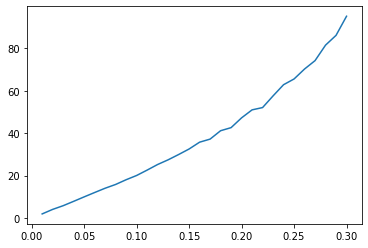

In [144]:
import matplotlib.pyplot as plt
plt.plot(result_x[:],avg_bumps)

In [177]:
avg_bumps

[1.932,
 4.068,
 5.804,
 7.864,
 9.964,
 12.02,
 14.044,
 15.82,
 18.048,
 20.048,
 22.584,
 25.224,
 27.432,
 29.924,
 32.536,
 35.748,
 37.196,
 41.148,
 42.6,
 47.216,
 50.98,
 52.064,
 57.564,
 62.84,
 65.544,
 70.236,
 74.192,
 81.492,
 86.1,
 95.112]

In [285]:
# import pickle
# with open('agent_3_avg_bumps.pkl', 'wb') as f:
#     pickle.dump(avg_bumps, f)

In [ ]:
p_values[:-1]

In [148]:
import pickle
with open('agent_2_avg_bumps.pkl', 'rb') as f:
    agent_2_avg_bumps = pickle.load(f)
with open('agent_1_avg_bumps.pkl', 'rb') as f:
    agent_1_avg_bumps = pickle.load(f)
with open('agent_3_avg_bumps.pkl', 'rb') as f:
    agent_3_avg_bumps = pickle.load(f)

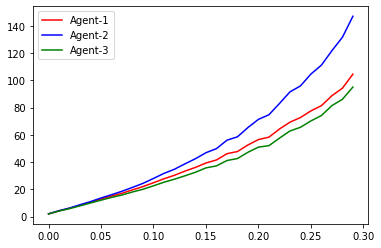

In [179]:
plt.plot(p_values[:-1], agent_1_avg_bumps,color = "red", label="Agent-1")
plt.plot(p_values[:-1], agent_2_avg_bumps,color = "blue", label="Agent-2")
plt.plot(p_values[:-1], np.array(avg_bumps),color = "green", label="Agent-3")
plt.legend()

In [48]:
for i in range(len(agent_1_avg_bumps)):
    print(agent_1_avg_bumps[i])

NameError: name 'agent_1_avg_bumps' is not defined

In [178]:
# import pickle
# with open('agent-3-better.pkl', 'wb') as f:
#     pickle.dump(avg_bumps, f)

In [ ]:
### Plots --> avg len of trajectory, avg number of cells processed, avg num of bumps
def calculate_path_length(ans_compute_path):
    ans = 0
    for x in ans_compute_path:
        ans = ans + len(x)-1
    return ans + 1
from tqdm import tqdm
cnt = 0
result_y = []
# p_values = np.round(p_values,2)
# result_x = p_values[1:50]
avg_num_cells_processed = []
avg_bumps = []
avg_astar = []
m = 101
n = 101
start = (0,0)
target = (m-1,n-1)
for p in tqdm(p_values):
    if p == 0 or  p== 1:
        continue
    print("Started for p: ",p)
    sum_num_cells_processed = 0
    sum_bumps = 0
    sum_astar = 0
    cnt = 0
    with open('C:/Users/karan/Desktop/Rutgers Courses/CS520/Project2/Grid_data/'+'p'+str(p)+'.txt') as f:
        grid_data = f.readlines()
        freq = 0
        for s in grid_data:
            new_s = ''
            for c in s:
                if(c == '.'):
                    new_s +='0'
                else:
                    new_s += '1'
            i = 0
            grid = [] ## matrix that contains full knowledge of gridworld
            m = 101
            n = 101
            start = (0,0)
            target = (m-1,n-1)
            while(i<m*n):
                grid.append(list(new_s[i:i+n]))
                i = i + n
            grid = np.array(grid)
            gridObject = GridWorld(grid, start, target, n, m) ### Original grid knowledge object
            agentGridObject = GridWorld(np.full((m,n),'0'), start, target, n, m) ### Agent Grid Object
            inference_agent = InferenceAgent3(agentGridObject) ### Inference Agent Grid
            grid_agent = Agent3(n,m,start,target,inference_agent,gridObject, agentGridObject)
            ans = grid_agent.compute_path()
            sum_num_cells_processed += grid_agent.sum_num_cells_processed
            sum_bumps += grid_agent.num_bumps
            sum_astar += grid_agent.sum_a_star
            cnt+=1
            if(cnt == 250):
                break
        avg_num_cells_processed.append(sum_num_cells_processed/250)
        avg_bumps.append(sum_bumps/250)
        avg_astar.append(sum_astar/250)
        